# re_LAISS

In [1]:
import os
import time
import datetime
import math
import numpy as np
import pandas as pd
import sys
import astro_ghost
import os
import subprocess
import seaborn as sns
from scipy.stats import gaussian_kde
from scipy.spatial.distance import euclidean
from dust_extinction.parameter_averages import G23
import astropy.units as u
from sfdmap2 import sfdmap
import corner
import matplotlib.pyplot as plt
import logging
from tqdm import tqdm
from statsmodels import robust

import requests
from requests.auth import HTTPBasicAuth

import warnings
warnings.filterwarnings("ignore")

# Switch the working directory to the one where this file is located
working_dir = os.path.abspath("")
os.chdir(working_dir)

sys.path.append('../code/')

import constants
from helper_functions import *
from laiss_functions import *
from mod_helper_functions import *
from mod_laiss_functions import *

## Build dataset bank

In [ ]:
# raw_dataset_bank = pd.read_csv('../data/dataset_bank_orig_w_hosts_ra_dec_5472objs.csv.gz')
# print("Shape of raw dataset bank:", raw_dataset_bank.shape)

# # Build final dataset bank
# final_dataset_bank = re_build_dataset_bank(raw_df_bank=raw_dataset_bank, av_in_raw_df_bank=False, path_to_sfd_folder="../data/sfddata-master")

# # Write dataset bank to .csv
# print("Shape of final dataset bank:", final_dataset_bank.shape)
# final_dataset_bank.to_csv('../data/final_standardized_dataset_bank_re_laiss.csv', index=False)
# print("Successfully saved dataset bank!")

Shape of raw dataset bank: (5472, 502)
Engineering features for band g...
Engineering features for band r...
Engineering features for band i...
Engineering features for band z...
Shape of final dataset bank: (5472, 519)
Successfully saved dataset bank!


## Run re_LAISS

No host features provided. Running lightcurve-only LAISS with 18 features.
Building new ANNOY index with 5472 transients...
Done!
ZTF21aaublej is in dataset_bank.
Loading previously saved ANNOY index without PCA: ../data/re_LAISS/index_files/re_laiss_annoy_index_pcaFalse_18lc_0host.ann
First neighbor is input transient, so it will be excluded. The final neighbor count will be one less than expected.
						 ZTFID     IAU_NAME SPEC  Z
Input transient: https://alerce.online/object/ZTF21aaublej 2021ixf SN Ia 0.041
Making a plot of stacked lightcurves...


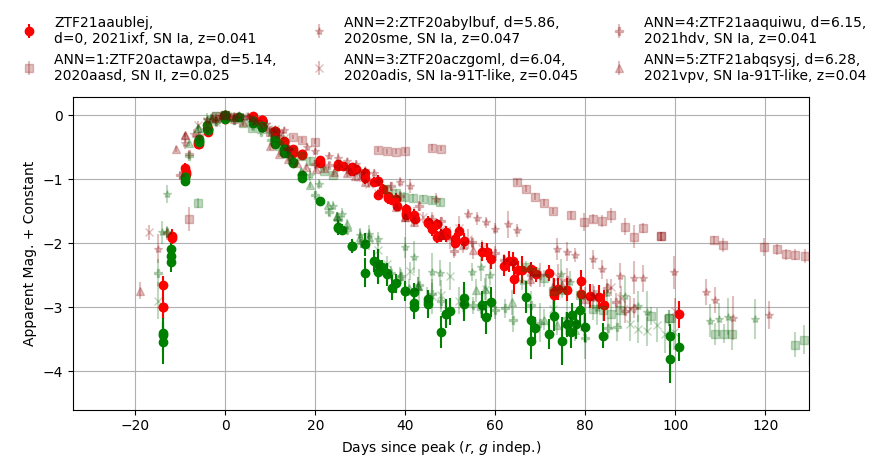

ANN=1: https://alerce.online/object/ZTF20actawpa 2020aasd SN II, 0.025
ANN=2: https://alerce.online/object/ZTF20abylbuf 2020sme SN Ia, 0.0468
ANN=3: https://alerce.online/object/ZTF20aczgoml 2020adis SN Ia-91T-like, 0.0453189984
ANN=4: https://alerce.online/object/ZTF21aaquiwu 2021hdv SN Ia, 0.04052
ANN=5: https://alerce.online/object/ZTF21abqsysj 2021vpv SN Ia-91T-like, 0.04

ANN elapsed_time: 0.009 s

total elapsed_time: 4.206 s


Running AD Model...
Checking if timeseries dataframe for ZTF21aaublej already exists...
Timeseries dataframe does not exist. Re-extracting lightcurve and host features for ZTF21aaublej.
Extracted lightcurve features for for ZTF21aaublej in 1.11s!
Found no hosts in GLADE.
Finding northern sources with Pan-starrs...


In [ ]:
lc_feature_names = constants.lc_features_const.copy()
host_feature_names = constants.host_features_const.copy()
queried_ztf_id = 'ZTF21aaublej' #ZTF23aadwlhl is a cool one

neighbors_df = re_LAISS(
    transient_ztf_id=queried_ztf_id, #ZTF24abeiqfc is not in dataset bank, ZTF21aaublej is in dataset bank
    host_ztf_id_to_swap_in=None,
    path_to_dataset_bank='../data/final_standardized_dataset_bank_re_laiss.csv',
    path_to_timeseries_folder = '../timeseries',
    host_feature_names=[],
    lc_feature_names=lc_feature_names,
    path_to_sfd_data_folder="../data/sfddata-master",
    use_pca=False,
    num_pca_components=None,
    force_recreation_of_annoy_index=True,
    index_folder_relative_path="../data/re_LAISS/index_files",
    path_to_ghost_database="../data/host_info",
    neighbors=6,
    suggest_neighbor_num=False,
    max_neighbor_distance=None,
    search_k=5000,
    return_neighbor_results=True,
    run_AD=True,
)

## re_LAISS performance analysis

Total number of transients for corner plots: 5472
Creating corner plot for lc1...
Total number of transients for corner plot after outlier removal: 5382


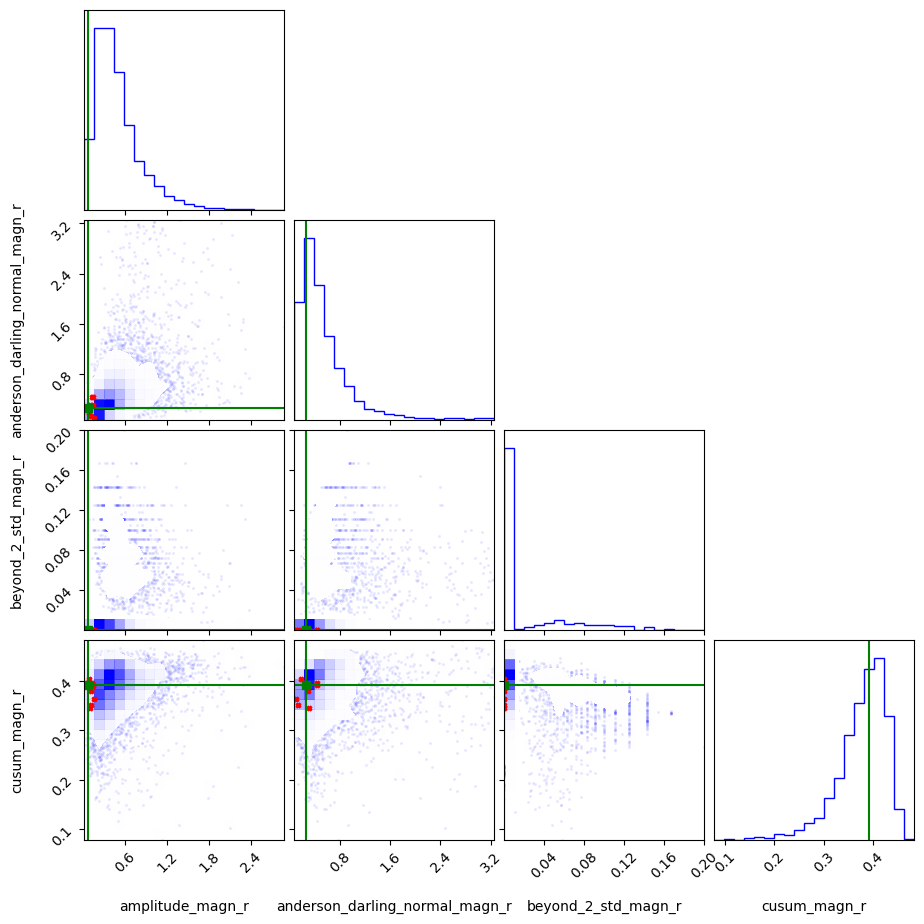

Creating corner plot for lc2...
Total number of transients for corner plot after outlier removal: 5461


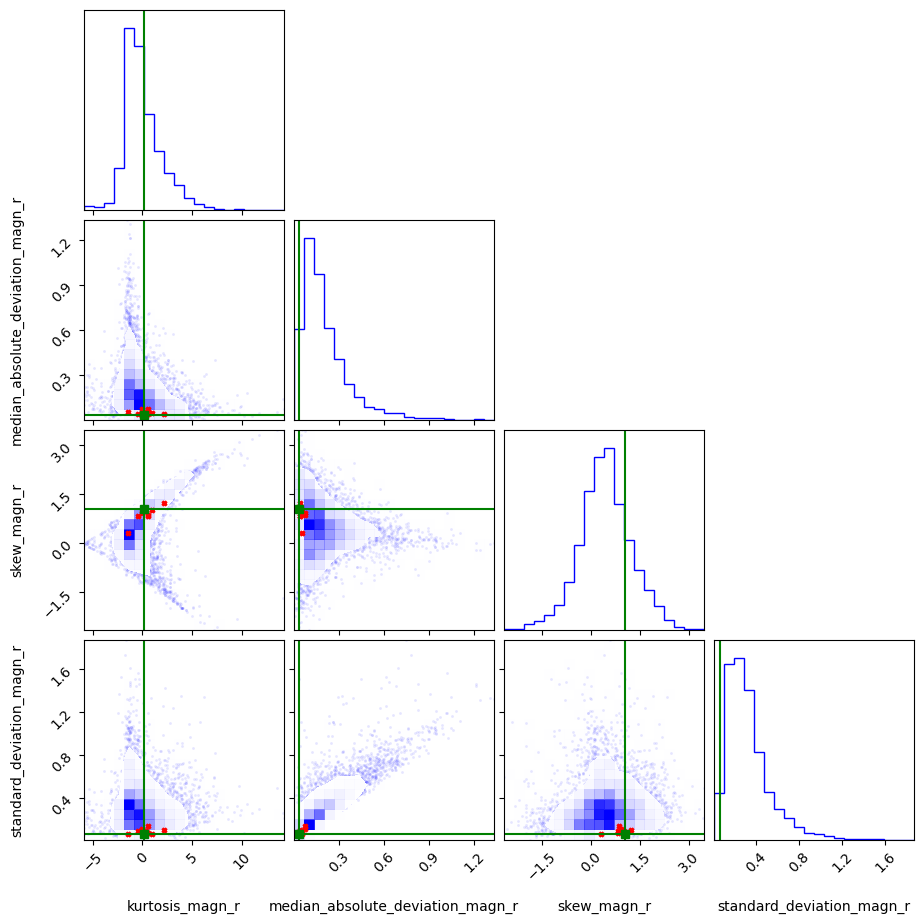

Creating corner plot for lc3...
Total number of transients for corner plot after outlier removal: 5422


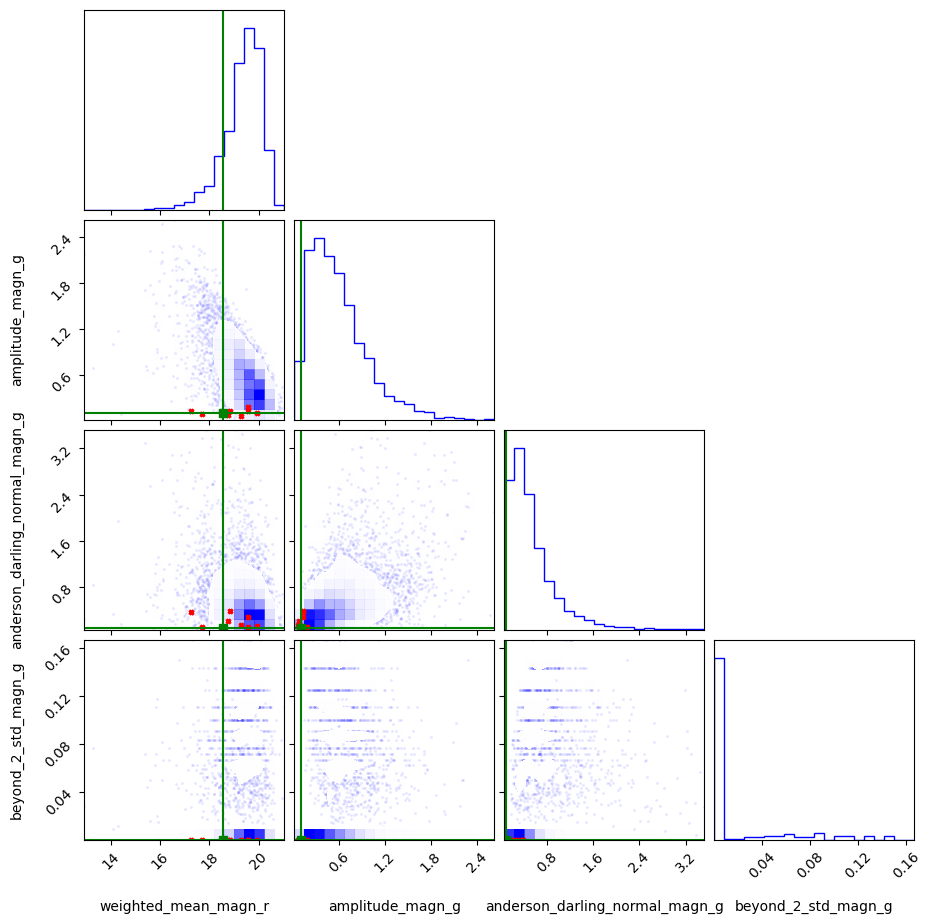

Creating corner plot for lc4...
Total number of transients for corner plot after outlier removal: 5470


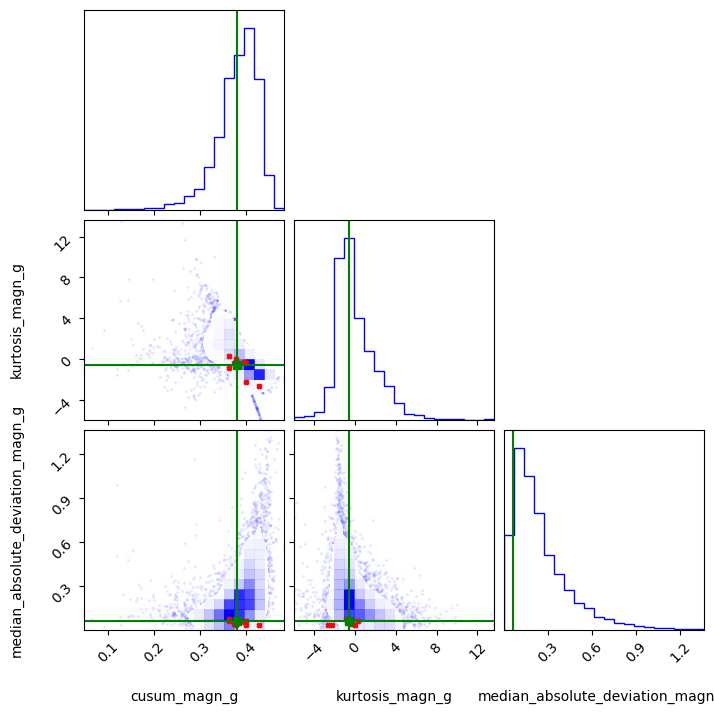

Creating corner plot for lc5...
Total number of transients for corner plot after outlier removal: 5472


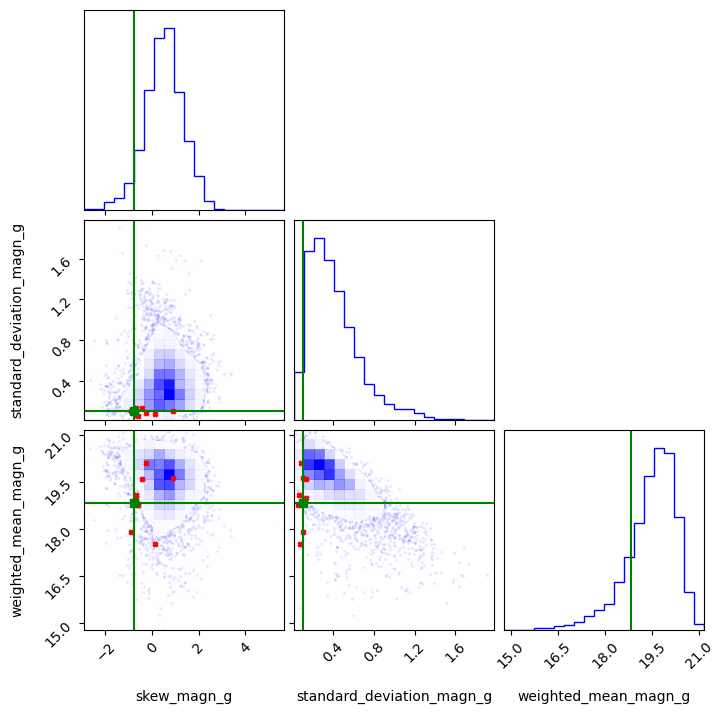

Creating corner plot for g_band...
Total number of transients for corner plot after outlier removal: 5471


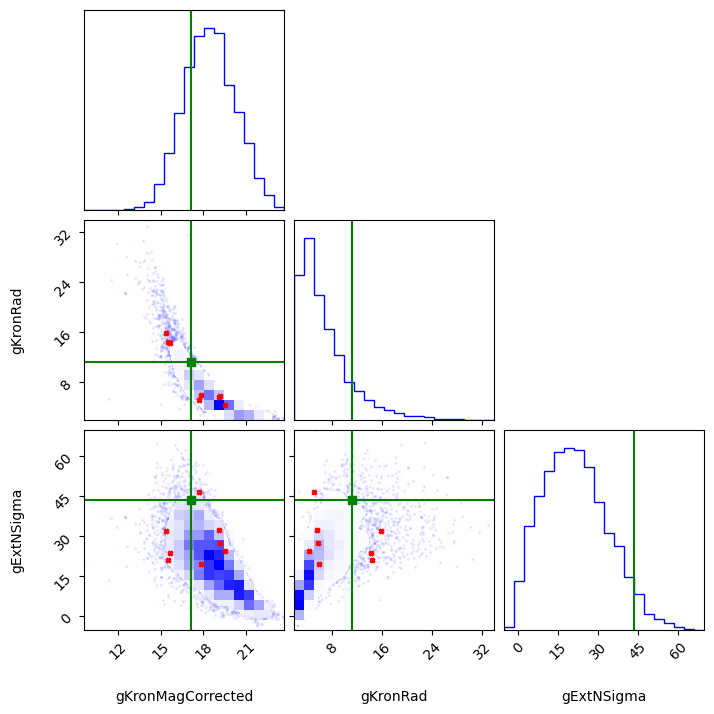

Creating corner plot for r_band...
Total number of transients for corner plot after outlier removal: 5471


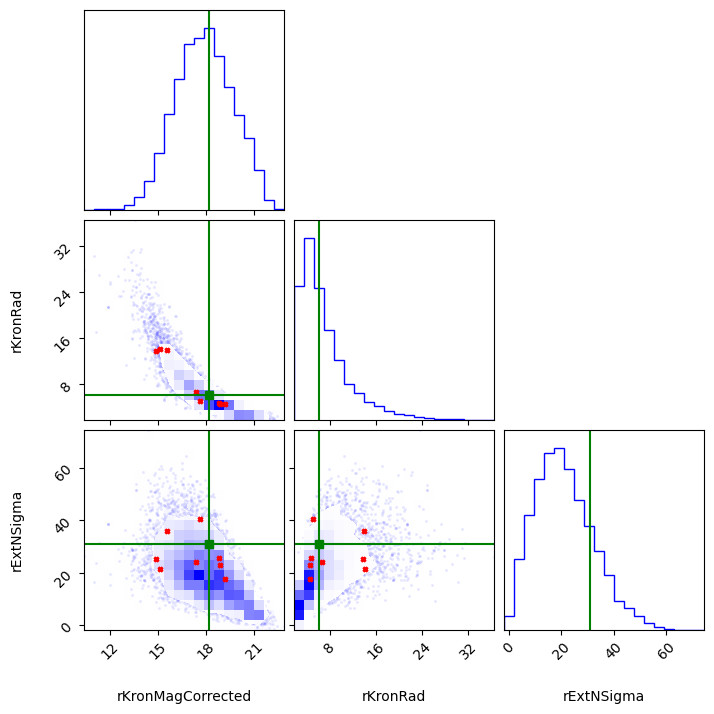

Creating corner plot for i_band...
Total number of transients for corner plot after outlier removal: 5471


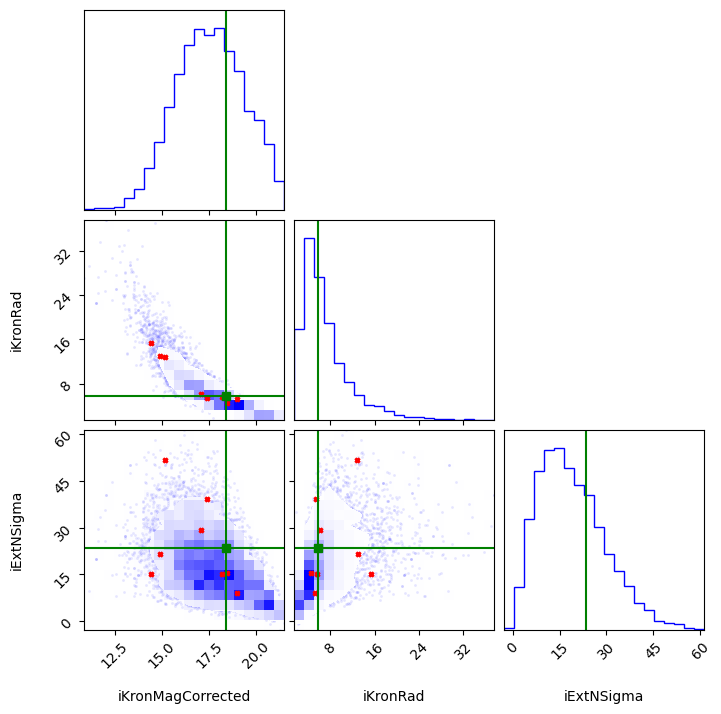

Creating corner plot for z_band...
Total number of transients for corner plot after outlier removal: 5472


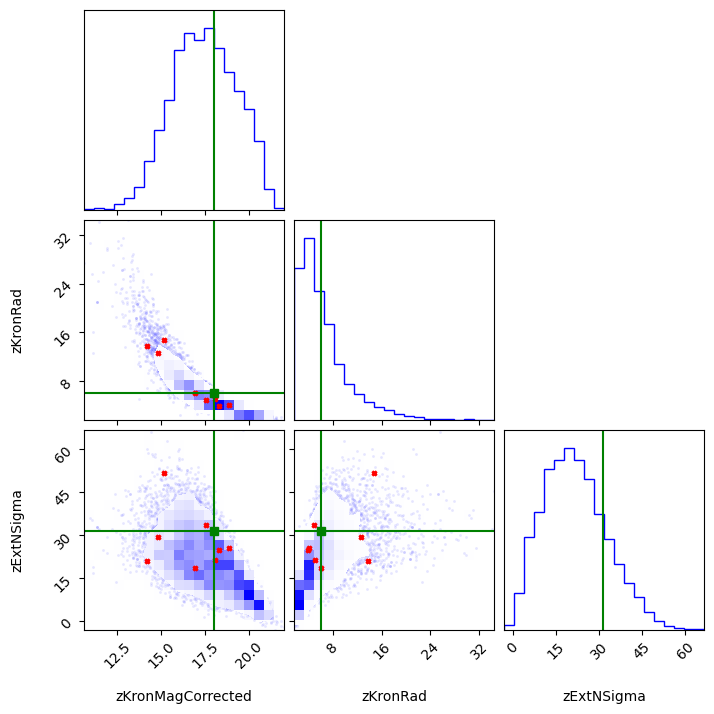

Creating corner plot for band_differences...
Total number of transients for corner plot after outlier removal: 5441


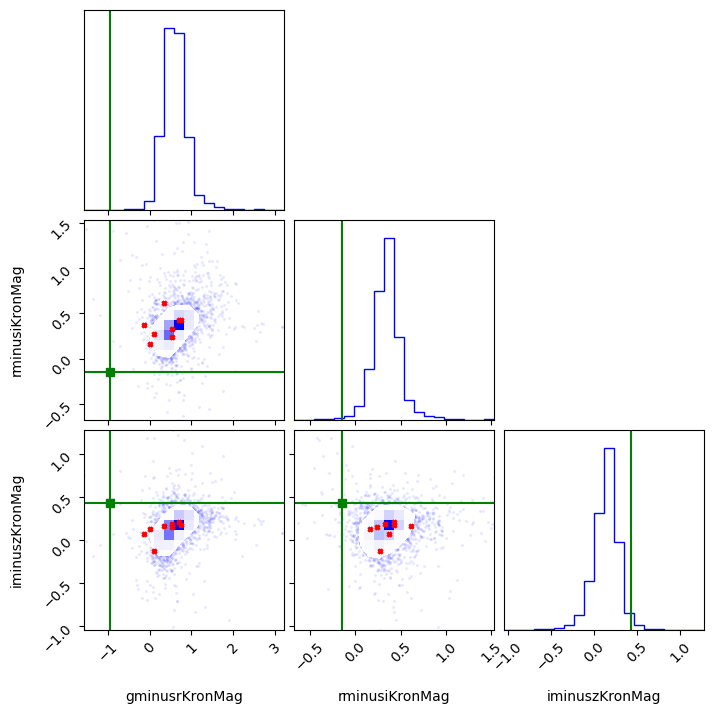

Finished creating all plots!


In [11]:
remove_outliers_bool = True

logging.getLogger().setLevel(logging.ERROR)

re_laiss_features_dict = {
    'lc1': ['feature_amplitude_magn_r', 'feature_anderson_darling_normal_magn_r', 'feature_beyond_2_std_magn_r', 'feature_cusum_magn_r'],
    'lc2': ['feature_kurtosis_magn_r', 'feature_median_absolute_deviation_magn_r', 'feature_skew_magn_r', "feature_standard_deviation_magn_r"],
    'lc3': ['feature_weighted_mean_magn_r', 'feature_amplitude_magn_g', 'feature_anderson_darling_normal_magn_g', 'feature_beyond_2_std_magn_g'],
    'lc4': ['feature_cusum_magn_g', 'feature_kurtosis_magn_g', 'feature_median_absolute_deviation_magn_g'],
    'lc5': ['feature_skew_magn_g', 'feature_standard_deviation_magn_g', 'feature_weighted_mean_magn_g'],
    'g_band': ['gKronMagCorrected', 'gKronRad', 'gExtNSigma'],
    'r_band': ['rKronMagCorrected', 'rKronRad', 'rExtNSigma'],
    'i_band': ['iKronMagCorrected', 'iKronRad', 'iExtNSigma'],
    'z_band': ['zKronMagCorrected', 'zKronRad', 'zExtNSigma'],
    'band_differences': ['gminusrKronMag', 'rminusiKronMag', 'iminuszKronMag']
}

neighbor_ztfids = [link.split("/")[-1] for link in neighbors_df["ztf_link"]]

dataset_bank_df = pd.read_csv('../data/final_dataset_bank_re_laiss.csv')[['ztf_object_id'] + lc_feature_names + host_feature_names]
print("Total number of transients for corner plots:", dataset_bank_df.shape[0])

for batch_name, features in re_laiss_features_dict.items():
    print(f"Creating corner plot for {batch_name}...")

    # REMOVING OUTLIERS #
    def remove_outliers(df, threshold=7):
        df_clean = df.copy()
        numeric_cols = df_clean.select_dtypes(include=[np.number]).columns

        for col in numeric_cols:
            col_data = df_clean[col]
            median_val = col_data.median()
            mad_val = robust.mad(col_data)  # By default uses 0.6745 scale factor internally

            # If MAD is zero, it means the column has too little variation (or all same values).
            # In that case, skip it to avoid removing all rows.
            if mad_val == 0:
                continue

            # Compute robust z-scores
            robust_z = 0.6745 * (col_data - median_val) / mad_val

            # Keep only points where the robust z-score is within the threshold
            df_clean = df_clean[abs(robust_z) <= threshold]

        return df_clean

    
    dataset_bank_df_batch_features = dataset_bank_df[['ztf_object_id'] + features]

    if remove_outliers_bool:
        dataset_bank_df_batch_features = remove_outliers(dataset_bank_df_batch_features)
        print("Total number of transients for corner plot after outlier removal:", dataset_bank_df_batch_features.shape[0])
    else:
        dataset_bank_df_batch_features = dataset_bank_df_batch_features.replace([np.inf, -np.inf, -999], np.nan).dropna()
        print("Total number of transients for corner plot after NA, inf, and -999 removal:", dataset_bank_df_batch_features.shape[0])
    # REMOVING OUTLIERS #

    neighbor_mask = dataset_bank_df_batch_features['ztf_object_id'].isin(neighbor_ztfids)
    features_df = dataset_bank_df_batch_features[features]

    # remove 'feature_' from column names
    features_df.columns = [
        col.replace("feature_", "", 1) if col.startswith("feature_") else col
        for col in features_df.columns
    ]

    neighbor_features = features_df[neighbor_mask]
    non_neighbor_features = features_df[~neighbor_mask]
    queried_features = dataset_bank_df_batch_features[dataset_bank_df_batch_features['ztf_object_id'] == queried_ztf_id].iloc[:,1:]
    queried_features_arr = queried_features.values[0]

    figure = corner.corner(non_neighbor_features, color='blue', labels=features_df.columns, plot_datapoints=True, alpha=0.3, plot_contours=False, truths=queried_features_arr, truth_color='green')
    
    # Overlay neighbor features (red) with larger, visible markers
    axes = np.array(figure.axes).reshape(len(features), len(features))
    for i in range(len(features)):
        for j in range(i):  # Only the lower triangle of the plot
            ax = axes[i, j]
            ax.scatter(
                neighbor_features.iloc[:, j], 
                neighbor_features.iloc[:, i], 
                color='red', 
                s=10,
                marker='x',
                linewidth=2
            )
    plt.show()

print("Finished creating all plots!")

In [ ]:
from mod_laiss_functions import re_get_timeseries_df

timeseries = re_get_timeseries_df(
    ztf_id='ZTF21aaublej',
    path_to_timeseries_folder='../timeseries',
    path_to_sfd_data_folder="../data/sfddata-master",
)

Checking if timeseries dataframe for ZTF21aaublej already exists...
Timeseries dataframe does not exist. Re-extracting lightcurve and host features for ZTF21aaublej.
Extracted lightcurve features for for ZTF21aaublej in 2.48s!
Found no hosts in GLADE.
Finding northern sources with Pan-starrs...
